In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## Data collection and description

In [2]:
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [3]:
df1 = df.copy()

In [4]:
df1.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
df1.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [6]:
df1.dtypes

Quarter     object
Sales      float64
dtype: object

In [7]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [8]:
temp = df1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [9]:
df1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [10]:
df1.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [11]:
df1 = df1.drop(['Quarter'], axis=1)

In [12]:
df1.reset_index(inplace=True)

In [13]:
df1['quater'] = pd.to_datetime(df1['quater'])

In [14]:
df1 = df1.set_index('quater')

In [15]:
df1.head()

,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


In [31]:
plt.rcParams["figure.figsize"] = (8,5.5)

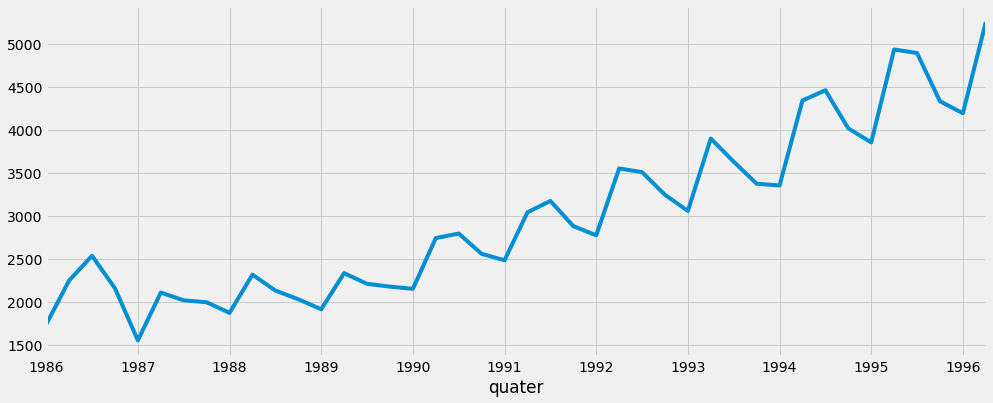

In [32]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

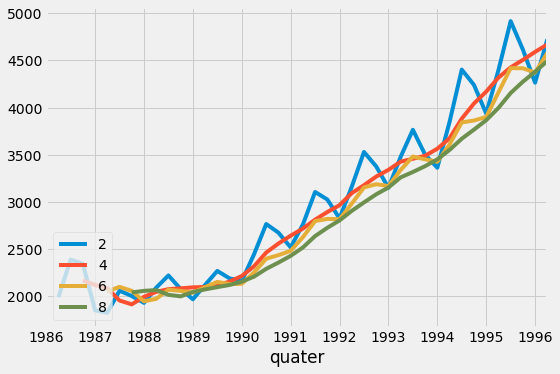

In [33]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

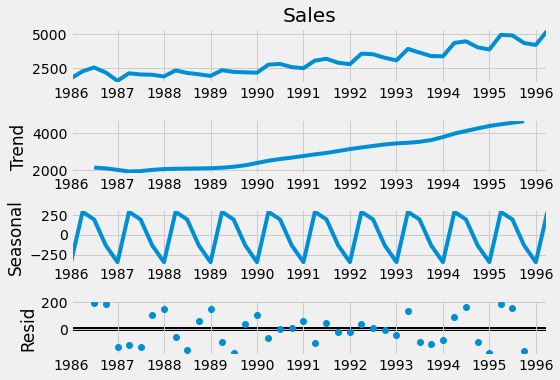

In [34]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

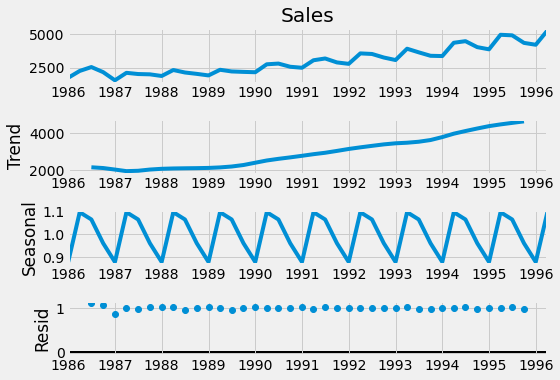

In [35]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

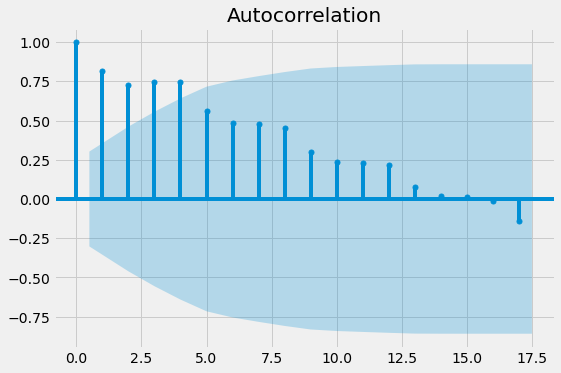

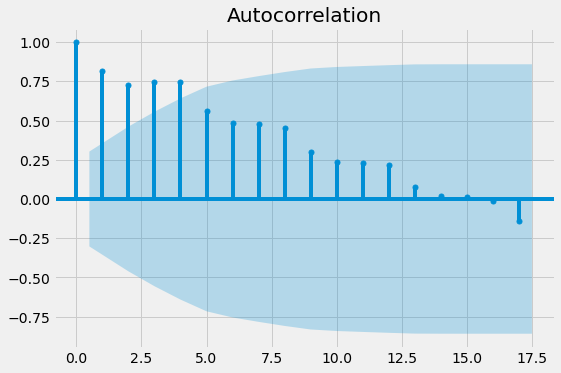

In [36]:
tsa_plots.plot_acf(df1.Sales)

## Building Time series forecasting with ARIMA

In [37]:
X = df1['Sales'].values

In [38]:
size = int(len(X) * 0.66)

In [39]:
train, test = X[0:size], X[size:len(X)]

In [40]:
model = ARIMA(train, order=(5,1,0))

In [41]:
model_fit = model.fit(disp=0)

In [42]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   26
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -172.036
Method:                       css-mle   S.D. of innovations            163.191
Date:                Tue, 01 Mar 2022   AIC                            358.071
Time:                        20:21:53   BIC                            366.878
Sample:                             1   HQIC                           360.607
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8434     26.509      1.578      0.114     -10.113      93.799
ar.L1.D.y     -0.1479      0.195     -0.758      0.448      -0.530       0.234
ar.L2.D.y     -0.3127      0.157     -1.996      0.0

### This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

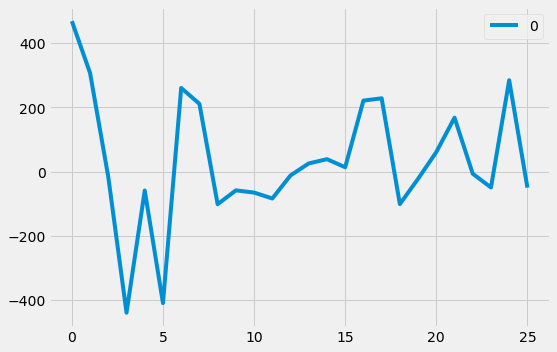

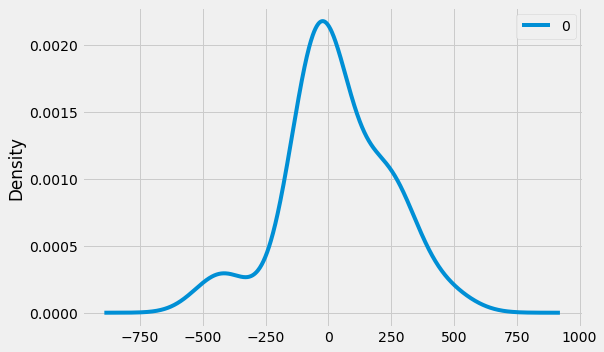

                0
count   26.000000
mean    31.325878
std    202.029702
min   -438.904389
25%    -58.603106
50%     -9.190229
75%    200.236018
max    468.290585


In [43]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### The plot of the residual errors suggests that there may still be some trend information not captured by the model  
### The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)  

### __3.1 - Rolling Forecast ARIMA Model__ 

In [44]:
history = [x for x in train]

In [45]:
predictions = list()

In [46]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3135.586029, expected=3243.859993
predicted=3188.847068, expected=3056.000000
predicted=3734.224502, expected=3899.000000
predicted=3782.620891, expected=3629.000000
predicted=3355.125969, expected=3373.000000
predicted=3297.218120, expected=3352.000000
predicted=4112.813891, expected=4342.000000
predicted=3961.043678, expected=4461.000000
predicted=4130.787225, expected=4017.000000
predicted=3912.794182, expected=3854.000000
predicted=4687.043733, expected=4936.000000
predicted=4970.516924, expected=4895.000000
predicted=4384.040534, expected=4333.000000
predicted=4207.687405, expected=4194.000000
predicted=5261.673040, expected=5253.000000


In [47]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 31525.273


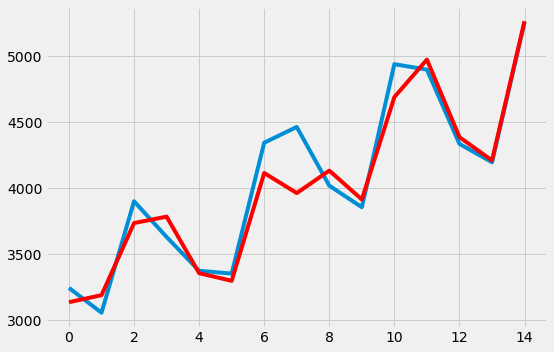

In [48]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale  

## Comparing Multiple Models

In [49]:
df2 = pd.get_dummies(df, columns = ['Quarter'])

In [50]:
df2.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']

In [51]:
df2.head()

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2154.962997,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
t= np.arange(1,43)

In [53]:
df2['t'] = t

In [54]:
df2['t_sq'] = df2['t']*df2['t']

In [55]:
log_Sales=np.log(df2['Sales'])

In [56]:
df2['log_Sales']=log_Sales

In [57]:
df2.head()

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,t,t_sq,log_Sales
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7.458663
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7.716443
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,7.837477
3,2154.962997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,7.675529
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,7.344602


In [58]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [252]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918641

In [253]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037103

In [254]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900134

In [255]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.718820918695

In [256]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372254

In [257]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.11444360548165

In [258]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.9194407954424

In [259]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.687911933419

In [260]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

3630.5619467355227

## __5 - Conclusion__ 

In [261]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [262]:
rmse=pd.DataFrame(output)

In [263]:
print(rmse)

           Model       Values
0  rmse_mul_quad  3630.561947
1        rmseadd  1869.718821
2  rmseaddlinear   596.152628
3    rmseaddquad   412.114444
4       rmseexpo   588.140510
5        rmselin   580.122413
6        rmsemul  2374.919441
7      rmsemulin  5359.687912
8       rmsequad   783.729798


### Additive seasonality with quadratic trend has the best RMSE value